# DATASCI W261: Machine Learning at Scale 

**Name: Carlos Eduardo Rodriguez Castillo**

**email: cerodriguez@berkeley.edu**

**Week 5**

**Section 2**

## HW 5.0
- What is a data warehouse? What is a Star schema? When is it used?

##### ANSWER:

__A data warehouse is a large storage facility for data that can come from a wide variety of sources and that can be in a wide variety of formats.__

__A Star schema is a commonly used and simple schema used to define how data is stored in a data storage facility (be it a database or a data warehouse for example).__ The Star schema organizes data records into fact tables that may reference one to many other dimension tables where fact tables tend to store records that represent events whereas dimension tables tend to store records that represent characteristics of objects that are involved in events recorded in fact tables.

The Star schema is widely used to represent data in a myriad of business applications. __Specifically, it is a very effective schema for the purposes of giving structure to data used by an OLTP (online transaction processing) system.__ This is in contrast to data used by OLAP (online analytical processing) systems.

## HW 5.1
- In the database world what is 3NF? Does machine learning use data in 3NF? If so why?

##### ANSWER:

In the database world, __3NF is the third of a standard set of normalization steps that are applied to databases in order to (1) reduce data duplication in the database and (2) ensure that all records__ (and as such any and all attributes for each record) __in the database can be unambiguously identified through a key__ (where the key is either a single attribute or a set of attributes).

__For the most part, machine learning does not use data in 3NF__; the reason being that the reduction in data duplication offered by 3NF actually stops the underlying distributed and sequential machine learning framework from properly identifying and subsequewntly processing records.

- In what form does ML consume data?

##### ANSWER:

Taking ML to mean machine learning, ML consumes data that is in a raw, denormalized format. Punctually, this would be logs produced by applications, users, or a combination of both.

- Why would one use log files that are denormalized?

##### ANSWER:

One would use log files that are denormalized for several of reasons. On one hand, denormalized logs provide the machine learning framework the most amount of context to operate on. That is, the more data is provided in each log or record, the more options the data scientist has to produce features for the ML framework to learn on.

On another hand, given the distributed and sequential nature of the MapReduce framework that supports most of modern ML at scale, denormalized log data has the representational redundancy that would permit a framework of this nature to identify, differentiate between and process records.

## HW 5.2
Using MRJob, implement a hashside join (memory-backed map-side) for left, right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)

Justify which table you chose as the Left table in this hashside join.

Please report the number of rows resulting from:

- (1) Left joining Table Left with Table Right
- (2) Right joining Table Left with Table Right
- (3) Inner joining Table Left with Table Right


##### ANSWER:

I choose the table with the URLs (URL ID and URL name) as the Left table in the hashside join because it is considerably smaller than the URL ID and USER ID visits; by definition we wish to store the smallest of the tables being merged as the in-memory stored table. See below for the number of rows resulting from each of the joins:

| |Inner Join|Left Outer Join|Right Outer Join|
|---|---|---|---|
|Number of rows|98654|98663|98654| |


In [10]:
#####################################
## Preprocessing/housekeeping
#####################################

## Create local directories for data

#!mkdir data
#!mkdir src

## Download data for 5.2

#!wget "https://www.dropbox.com/sh/m0nxsf4vs5cyrp2/AADCHtrJ4CBCDO1po_OAWg0ia/anonymous-msweb.data?dl=0#"
#!mv "anonymous-msweb.data?dl=0" data/anonymous-msweb.data
#!egrep "^A," data/anonymous-msweb.data > data/URL_table.txt
#!head data/URL_table.txt
#!wc -l data/URL_table.txt

In [6]:
%%writefile src/preprocess.py
#!/usr/bin/python
"""
Single node data preprocessing for HW4.2
"""
__author__ = "Carlos Eduardo Rodriguez Castillo"
__email__ = "cerodriguez@berkeley.edu"

import sys
import re

url_dict = {}

for line in sys.stdin:
    line = line.strip()
    elements = line.split(",")
    ## When a line starts with C we start 
    ## recording data for the customer
    if elements[0] == 'C':
        visitor_data = elements[0] + ',' + elements[2]
        continue
    ## When a line starts with V we start 
    ## recording data for the visit to a URL
    elif elements[0] == 'V':
        ## this is formatted as 'V,[URL_ID]
        visit_data = elements[0] + ',' + elements[1]
        ## this is formatted as 'V,[URL_ID],C,[USER_ID]
        processed_line = visit_data + ',' + visitor_data
        print processed_line

Writing src/preprocess.py


In [7]:
!chmod a+x src/preprocess.py
!./src/preprocess.py < data/anonymous-msweb.data \
> data/preprocessed_anonymous-msweb.data

In [3]:
%%writefile src/InnerJoinMRjob.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os

class InnerJoinMRjob(MRJob):
    
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper
            )
        ]
    in_memory_hash = {}
    def mapper_init(self):
        ## Upon initializing a mapper
        ## we load into memory a dictionary
        ## that holds the URL table
        temp = [s.split('\n')[0].split(',') for s in open("/home/cloudera/w261/HW5/data/URL_table.txt", "r").readlines()]
        for row in temp:
            self.in_memory_hash[row[1]] = 'http://www.microsoft.com' + row[4].strip('"')
    
    def mapper(self, _, line):
        line = line.strip()
        elements = line.split(',')
        url_id = elements[1]
        user_id = elements[3]
        ## for each record being processed by the mapper
        ## we retrieve the URL in the in-memory hash
        ## based on the URL ID of the record
        url = self.in_memory_hash[url_id]
        yield url_id, (url, user_id)
    
if __name__ == '__main__':
    InnerJoinMRjob().run()

Overwriting src/InnerJoinMRjob.py


In [2]:
!chmod a+x src/InnerJoinMRjob.py
!./src/InnerJoinMRjob.py data/preprocessed_anonymous-msweb.data > output_InnerJoin

In [3]:
%%writefile src/RightOuterJoinMRjob.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os

class RightOuterJoinMRjob(MRJob):
    
    def steps(self):
        return [
            MRStep(mapper_init=self.mapper_init,
                   mapper=self.mapper
            )
        ]
    COUNTER = 0
    in_memory_hash = {}
    def mapper_init(self):
        ## Upon initializing a mapper
        ## we load into memory a dictionary
        ## that holds the URL table
        temp = [s.split('\n')[0].split(',') for s in open("/home/cloudera/w261/HW5/data/URL_table.txt", "r").readlines()]
        for row in temp:
            self.in_memory_hash[row[1]] = 'http://www.microsoft.com' + row[4].strip('"')
    
    def mapper(self, _, line):
        line = line.strip()
        elements = line.split(',')
        url_id = elements[1]
        user_id = elements[3]
        ## Since this is a Right Outer Join
        ## we only emmit a result if there is a record
        ## in our URL hash for the record being processed
        ## in this case, the result is identical to the Inner Join
        try:
            url = self.in_memory_hash[url_id]
        except KeyError:
            sys.stderr.write("Did not find a URL for URL ID: %s"%url_id)
            url = "NULL"
        yield url_id, (url, user_id)
    
if __name__ == '__main__':
    RightOuterJoinMRjob().run()

Overwriting src/RightOuterJoinMRjob.py


In [4]:
!chmod a+x src/RightOuterJoinMRjob.py
!./src/RightOuterJoinMRjob.py data/preprocessed_anonymous-msweb.data > output_RightOuterJoin

No configs found; falling back on auto-configuration
Creating temp directory /tmp/RightOuterJoinMRjob.cloudera.20160615.211408.396808
Running step 1 of 1...
Streaming final output from /tmp/RightOuterJoinMRjob.cloudera.20160615.211408.396808/output...
Removing temp directory /tmp/RightOuterJoinMRjob.cloudera.20160615.211408.396808...


In [5]:
%%writefile src/LeftOuterJoinMRjob.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os

class LeftOuterJoinMRjob(MRJob):
    
    def steps(self):
        JOB_CONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 2,
            'stream.map.output.field.separator':',',
            'mapreduce.partition.keycomparator.options': "-k1,1 -k2,2r", # sort pages by count and then by ID
             'mapreduce.job.reduces': 1,
            'mapreduce.job.maps': 1
            
        }
        return [
            MRStep(jobconf=JOB_CONF_STEP,
                mapper_init=self.mapper_init,
                   mapper=self.mapper,
                   mapper_final=self.mapper_final,
                   reducer=self.reducer
            )
        ]
    COUNTER = 0
    in_memory_hash = {}
    visited_hash = {}
    def mapper_init(self):
        ## Upon initializing a mapper
        ## we load into memory a dictionary
        ## that holds the URL table
        ## We also keep track of whether a URL
        ## has been visited
        temp = [s.split('\n')[0].split(',') for s in open("/home/cloudera/w261/HW5/data/URL_table.txt", "r").readlines()]
        for row in temp:
            self.in_memory_hash[row[1]] = {"url":'http://www.microsoft.com' + row[4].strip('"'),"visited":0}
    
    def mapper(self, _, line):
        ## for each record processed
        ## we mark the associated URL as 
        ## being visited
        line = line.strip()
        elements = line.split(',')
        url_id = elements[1]
        user_id = elements[3]
        self.in_memory_hash[url_id]["visited"] = 1
        try:
            url = self.in_memory_hash[url_id]["url"]
        except KeyError:
            sys.stderr.write("Did not find a URL for URL ID: %s\n"%url_id)
            url = "NULL"
        yield (1, (url_id, url, user_id))
        
    def mapper_final(self):
        ## If there are URLs that have not been visited
        ## we keep track to publish in the output table
        ## for the Left Outer Join
        for key in self.in_memory_hash.keys():
            if self.in_memory_hash[key]["visited"] == 0:
                yield (99, (key, self.in_memory_hash[key]["url"], "NULL"))
        
    def reducer(self, visited, visit_tuples):
        ## In the reducer I publish all the matches but
        ## also all the records in the URL table 
        ## that did not have a match
        prev_url_id = ""
        if int(visited) == 99:
            for vt in visit_tuples:
                url_id = vt[0]
                url = vt[1]
                if prev_url_id != url_id:
                    prev_url_id = url_id
                    yield url_id, (url,"NULL")
        else:
            for vt in visit_tuples:
                url_id = vt[0]
                url = vt[1]
                uid = vt[2]
                yield url_id, (url, uid)
    
if __name__ == '__main__':
    LeftOuterJoinMRjob().run()

Overwriting src/LeftOuterJoinMRjob.py


In [6]:
!chmod a+x src/LeftOuterJoinMRjob.py
!./src/LeftOuterJoinMRjob.py data/preprocessed_anonymous-msweb.data > output_LeftOuterJoin

No configs found; falling back on auto-configuration
Creating temp directory /tmp/LeftOuterJoinMRjob.cloudera.20160615.211419.631194
Running step 1 of 1...
Streaming final output from /tmp/LeftOuterJoinMRjob.cloudera.20160615.211419.631194/output...
Removing temp directory /tmp/LeftOuterJoinMRjob.cloudera.20160615.211419.631194...


In [7]:
## Comparing results below

!echo "############################"
!echo "##     INNER JOIN ROWS    ##"
!echo "############################"
!wc -l output_InnerJoin
!echo "############################"
!echo "##  LEFT OUTER JOIN ROWS  ##"
!echo "############################"
!wc -l output_LeftOuterJoin
!echo "############################"
!echo "## RIGHT OUTER JOIN ROWS  ##"
!echo "############################"
!wc -l output_RightOuterJoin

############################
##     INNER JOIN ROWS    ##
############################
98654 output_InnerJoin
############################
##  LEFT OUTER JOIN ROWS  ##
############################
98663 output_LeftOuterJoin
############################
## RIGHT OUTER JOIN ROWS  ##
############################
98654 output_RightOuterJoin


## HW 5.3  EDA of Google n-grams dataset
A large subset of the Google n-grams dataset

https://aws.amazon.com/datasets/google-books-ngrams/

which we have placed in a bucket/folder on Dropbox on s3:

https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=0 

s3://filtered-5grams/

In particular, this bucket contains (~200) files (10Meg each) in the format:

	(ngram) \t (count) \t (pages_count) \t (books_count)

For HW 5.3-5.5, for the Google n-grams dataset unit test and regression test your code using the 
first 10 lines of the following file:

googlebooks-eng-all-5gram-20090715-0-filtered.txt

Once you are happy with your test results proceed to generating  your results on the Google n-grams dataset. 

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (please use the count information), i.e., unigrams
- 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

##### AMSWER:
- The longest 5-gram by number of characters is **AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR** with **159 characters**.
- The top 10 most frequent words (unigrams) in decreasing order of frequency are:

|Word|Frequency|
|---|---|
|the|5490815394|
|of|3698583299|
|to|2227866570|
|in|1421312776|
|a|1361123022|
|and|1149577477|
|that|802921147|
|is|758328796|
|be|688707130|
|as|492170314|

- The 20 most densely appearing words in decreasing order of relative frequency are:

|Word|Relative Frequency|
|---|---|
|xxxx|11.5572916667|
|blah|8.0741599073|
|nnn|7.53333333333|
|na|6.20174913142|
|oooooooooooooooo|4.921875|
|nd|4.85430572724|
|llll|4.51162790698|
|oooooo|4.16965001336|
|ooooo|3.85863719347|
|lillelu|3.76245210728|
|madarassy|3.57692307692|
|pfeffermann|3.57692307692|
|meteoritical|3.56|
|xxxxxxxx|3.5|
|beep|3.22903885481|
|latha|3.18867924528|
|iyengar|2.91911764706|
|counterfeiteth|2.825|
|nonmorular|2.81981981982|
|nonsquamous|2.81981981982|

- The 20 least densely appearing words in decreasing order of relative frequency are:

|Word|Relative Frequency|
|---|---|
|zwingst|1.0|
|zwirnen|1.0|
|zwischenstaatlicher|1.0|
|zwitterionic|1.0|
|zwt|1.0|
|zwyn|1.0|
|zx|1.0|
|zxcvframeqasfuc|1.0|
|zydeco|1.0|
|zydom|1.0|
|zygmunt|1.0|
|zygomaticofacial|1.0|
|zygomaticotemporal|1.0|
|zygosity|1.0|
|zylindrischen|1.0|
|zymelman|1.0|
|zymogens|1.0|
|zymophore|1.0|
|zymosan|1.0|
|zymosis|1.0|

In [95]:
#####################################
## Preprocessing/housekeeping
#####################################

# !wget "https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACr50woxiBWoaiiLmnwduX8a/googlebooks-eng-all-5gram-20090715-0-filtered.txt?dl=0#"
# !mv "googlebooks-eng-all-5gram-20090715-0-filtered.txt?dl=0" data/googlebooks-eng-all-5gram-20090715-0-filtered.txt
# !head -n 10 data/googlebooks-eng-all-5gram-20090715-0-filtered.txt > data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt
# !cat data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt

In [92]:
%%writefile src/eda_1.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import sys
import os
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol

class Longest5ngramJob(MRJob):
    
    # Settings for sorting
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        ## Note that we are explicitly setting 
        ## multiple reducers, we are considering the 
        ## full output of the mappers as a key for the
        ## shuffle phase, setting partitioners based on 
        ## artificial partition keys and we are sorting
        ## based on the length of the 5-grams
        JOB_CONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 3,
            'stream.map.output.field.separator':'/t',
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.partition.keycomparator.options': "-k3,3nr -k2,2",
             'mapreduce.job.reduces': 10,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(jobconf=JOB_CONF_STEP,
                   mapper=self.mapper,
                   reducer=self.reducer
            )
        ]
    
    ## Notice that we are emmitting artificial 
    ## keys to ensure that the partitioners can 
    ## key off of them and guarantee sorted output
    def mapper(self, _, line):
        ngram = line.split("\t")[0]
        key = ngram
        value = len(ngram)
        if int(value) >= 6000:
            yield 'a', key+"\t"+str(value)
        elif int(value) >= 3000:
            yield 'b', key+"\t"+str(value)
        elif int(value) >= 1500:
            yield 'c', key+"\t"+str(value)
        elif int(value) >= 750:
            yield 'd', key+"\t"+str(value)
        elif int(value) >= 375:
            yield 'e', key+"\t"+str(value)
        elif int(value) >= 186:
            yield 'f', key+"\t"+str(value)
        elif int(value) >= 93:
            yield 'g', key+"\t"+str(value)
        elif int(value) >= 45:
            yield 'h', key+"\t"+str(value)
        elif int(value) >= 25:
            yield 'i', key+"\t"+str(value)
        else:
            yield 'j', key+"\t"+str(value)

    ## I ignore the key as it was only used
    ## for sorting
    def reducer(self,key,value):
        for v in value:
            yield None, v

if __name__ == "__main__":
    Longest5ngramJob().run()

Overwriting src/eda_1.py


In [ ]:
!chmod a+x src/eda_1.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/EDA_1/ --recursive
!python ~/w261/HW5/src/eda_1.py -r emr s3://filtered-5grams \
    --output-dir=s3://cerc-w261/HW5/5-2/output/EDA_1 \
        --no-output
!mkdir ~/w261/HW5/output
!mkdir ~/w261/HW5/output/EDA_1
!aws s3 cp s3://cerc-w261/HW5/5-2/output/EDA_1/ output/EDA_1 --recursive
!head -n 1  ~/w261/HW5/output/EDA_1/pa* | sort -k2,2nr | head -n 1

In [118]:
%%writefile src/eda_2.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol
import mrjob
import sys
import os

class UnigramCounterJob(MRJob):
    
    # Settings for sorting
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        ## Note that we are explicitly setting 
        ## multiple reducers, we are considering the 
        ## full output of the mappers as a key for the
        ## shuffle phase, setting partitioners based on 
        ## artificial partition keys and we are sorting
        ## based on the word frequencies
        JOB_CONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 3,
            'stream.map.output.field.separator':'/t',
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.partition.keycomparator.options': "-k3,3nr -k2,2",
             'mapreduce.job.reduces': 10,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(
                   mapper=self.mapper,
                   combiner=self.combiner,
                   reducer=self.reducer
            ),
            MRStep(jobconf=JOB_CONF_STEP,
                   mapper=self.sortMapper,
                   reducer=self.sortReducer
            )
        ]
    
    def mapper(self, _, line):
        line = line.strip()
        ngram_elements = line.split("\t")
        ngram = ngram_elements[0]
        count = int(ngram_elements[1])
        unigrams = ngram.split()
        for unigram in unigrams:
            yield unigram.lower(), str(count)

    def combiner(self, key, value):
        temp_sum = 0
        for v in value:
            temp_sum += int(v)
        yield key, str(temp_sum)
    
    def reducer(self, key, value):
        temp_sum = 0
        for v in value:
            temp_sum += int(v)
        yield key, str(temp_sum)
    
    def sortMapper(self, key, value):
        if int(value) >= 6000:
            yield 'a', key+"\t"+str(value)
        elif int(value) >= 3000:
            yield 'b', key+"\t"+str(value)
        elif int(value) >= 1500:
            yield 'c', key+"\t"+str(value)
        elif int(value) >= 750:
            yield 'd', key+"\t"+str(value)
        elif int(value) >= 375:
            yield 'e', key+"\t"+str(value)
        elif int(value) >= 186:
            yield 'f', key+"\t"+str(value)
        elif int(value) >= 93:
            yield 'g', key+"\t"+str(value)
        elif int(value) >= 45:
            yield 'h', key+"\t"+str(value)
        elif int(value) >= 25:
            yield 'i', key+"\t"+str(value)
        else:
            yield 'j', key+"\t"+str(value)

    ## I ignore the key as it was only used
    ## for sorting    
    def sortReducer(self, key, value):
        for v in value:
            yield None, v

if __name__ == "__main__":
    UnigramCounterJob().run()

Overwriting src/eda_2.py


In [ ]:
!chmod a+x src/eda_2.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/EDA_2/ --recursive
!python ~/w261/HW5/src/eda_2.py -r emr s3://filtered-5grams \
    --output-dir=s3://cerc-w261/HW5/5-2/output/EDA_2 \
        --no-output
!mkdir ~/w261/HW5/output/EDA_2
!aws s3 cp s3://cerc-w261/HW5/5-2/output/EDA_2/ output/EDA_2 --recursive
!head -n 10 ~/w261/HW5/output/EDA_2/pa* | sort -k2,2nr | head -n 10

In [132]:
%%writefile src/eda_3.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol
import mrjob
import sys
import os

class WordFrequencyJob(MRJob):
    
    # Settings for sorting
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        ## Note that we are explicitly setting 
        ## multiple reducers, we are considering the 
        ## full output of the mappers as a key for the
        ## shuffle phase, setting partitioners based on 
        ## artificial partition keys and we are sorting
        ## based on the word relative frequencies
        JOB_CONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 3,
            'stream.map.output.field.separator':'/t',
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.partition.keycomparator.options': "-k3,3nr -k2,2",
             'mapreduce.job.reduces': 7,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(
                   mapper=self.mapper,
                   reducer=self.reducer
            ),
            MRStep(jobconf=JOB_CONF_STEP,
                   mapper=self.sortMapper,
                   reducer=self.sortReducer
            )
        ]
    
    def mapper(self, _, line):
        line = line.strip()
        ngram_elements = line.split("\t")
        ngram = ngram_elements[0]
        count = int(ngram_elements[1])
        page_count = int(ngram_elements[2])
        unigrams = ngram.split()
        for unigram in unigrams:
            yield unigram.lower(), str(count)+"\t"+str(page_count)
    
    def reducer (self, key, value):
        total_count, total_page_count = 0, 0
        for val in value:
            val = val.split("\t")
            total_count += int(val[0])
            total_page_count += int(val[1])
        yield key, str(float(total_count)/float(total_page_count))
    
    def sortMapper(self, key, value):
        if float(value) >= 2:
            yield 'a', key+"\t"+str(value)
        elif float(value) >= 1:
            yield 'b', key+"\t"+str(value)
        elif float(value) >= 0.5:
            yield 'c', key+"\t"+str(value)
        elif float(value) >= 0.25:
            yield 'd', key+"\t"+str(value)
        elif float(value) >= 0.125:
            yield 'e', key+"\t"+str(value)
        elif float(value) >= 0.0625:
            yield 'f', key+"\t"+str(value)
        else:
            yield 'g', key+"\t"+str(value)
            
    ## I ignore the key as it was only used
    ## for sorting   
    def sortReducer(self, key, value):
        for v in value:
            yield None, v

if __name__ == "__main__":
    WordFrequencyJob().run()

Overwriting src/eda_3.py


In [ ]:
!chmod a+x src/eda_3.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/EDA_3/ --recursive
!python ~/w261/HW5/src/eda_3.py -r emr s3://filtered-5grams \
    --output-dir=s3://cerc-w261/HW5/5-2/output/EDA_3 \
        --no-output
!mkdir ~/w261/HW5/output/EDA_3
!aws s3 cp s3://cerc-w261/HW5/5-2/output/EDA_3/ output/EDA_3 --recursive
!head -n 20 ~/w261/HW5/output/EDA_3/pa* | sort -k2,2nr | head -n 20
!tail -n 20 ~/w261/HW5/output/EDA_3/pa* | sort -k2,2nr | tail -n 50

In [135]:
# !chmod a+x src/eda_3.py
# !./src/eda_3.py -r local \
#  data/mini-googlebooks-eng-all-5gram-20090715-0-filtered.txt \
#     > output_eda3_1
# !head -n 20 output_eda3_1
# !tail -n 20 output_eda3_1

0    33
1    33
2    29
3    28
4    27
5    26
6    24
7    23
8    22
9    17
Name: 1, dtype: int64


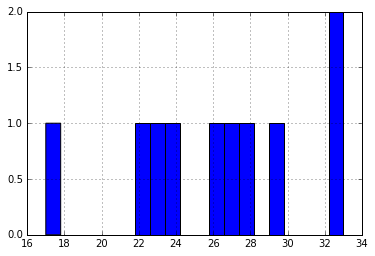

In [89]:
%matplotlib inline
import pandas as pd


df = pd.read_csv("output_eda1",
                 sep='\t',
                header=None)

counts = pd.Series(df[1])
print counts
counts.hist(bins=20)

## HW 5.3.1 OPTIONAL Question:
Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law

## HW 5.4  Synonym detection over 2Gig of Data

For the remainder of this assignment you will work with two datasets:

### 1: unit/systems test data set: SYSTEMS TEST DATASET
Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

- DocA {X:20, Y:30, Z:5}
- DocB {X:100, Y:20}
- DocC {M:5, N:20, Z:5, Y:1}

### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

(1) Build stripes for the most frequent 10,000 words using co-occurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


(2) Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

==Design notes for (1)==
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

==Design notes for (2)==
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!



##### ANSWER:

For the purposes of completing this exercise I used an __AWS EMR cluster with 15 m3.xlarge nodes__.

I opted for computing Cosine similarity and Jaccard similarity as defined in table one, page five of [this paper](http://stanford.edu/~rezab/papers/disco.pdf).

As far as runtime for the different jobs, please see below:

|MR Job|CPU time spent (ms)|GC time elapsed (ms)|
|---|---|---|
|Stripe Construction|1,235,070|76,579|
|Inverted Index Construction|307,260|51,058|
|Cosine Similarity Synonyms Construction|18,890,970|90,239|
|Jaccard Similarity Synonyms Construction|18,567,340|88,243|
|Cosine Similarity Synonyms Sort|1,703,220|58,250|
|Jaccard Similarity Synonyms Sort|1,706,380|58,293|


As far as systems tests are concerned, __It is important to note that, while the systems data set was useful to test base functionality, there were critical issues and cases that remained uncovered by the systems test data set; the main of which were memory errors encountered when processing the production data set.__

The results obtained for the systems test data set were as follows:

__Inverted Index Construction__

    "M"	{"C": {"length": 4, "sim": 0.5}}
    "N"	{"C": {"length": 4, "sim": 0.5}}
    "X"	{"A": {"length": 3, "sim": 0.57735026918962584}, "B": {"length": 2, "sim": 0.70710678118654746}}
    "Y"	{"A": {"length": 3, "sim": 0.57735026918962584}, "C": {"length": 4, "sim": 0.5}, "B": {"length": 2, "sim": 0.70710678118654746}}
    "Z"	{"A": {"length": 3, "sim": 0.57735026918962584}, "C": {"length": 4, "sim": 0.5}}
    
__Cosine Similarity Construction__

    "A.B"	0.81649658092772592
    "A.C"	0.57735026918962584
    "B.C"	0.35355339059327373

__Jaccard Similarity Construction__

    "B.C"	0.2
    "A.B"	0.6666666666666666
    "A.C"	0.4

The results for the production data set jobs can be found in s3:

|MR Job|Results S3 Location|
|---|---|
|Stripe Construction|s3://cerc-w261/HW5/5-2/output/Stripes/|
|Inverted Index Construction|s3://cerc-w261/HW5/5-2/output/InvertedIndices/|
|Cosine Similarity Synonyms Construction|s3://cerc-w261/HW5/5-2/output/CosineSim/|
|Jaccard Similarity Synonyms Construction|s3://cerc-w261/HW5/5-2/output/JaccardSim/|
|Cosine Similarity Synonyms Sort|s3://cerc-w261/HW5/5-2/output/SortedCosineSim/|
|Jaccard Similarity Synonyms Sort|s3://cerc-w261/HW5/5-2/output/SortedJaccardSim/|

In [59]:
%%writefile src/createStripesJob_1.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import mrjob
import sys
import os
import ast
from math import *
import urllib


class createStripesJob_1(MRJob):

    stopwords = set()
    top10000words = set()
    vocabulary = set()
    
    def steps(self):
        return [
            MRStep(mapper_init=self.stripeMapper_init,
                   mapper=self.stripeMapper,
                   reducer=self.stripeReducer
            )
        ]

    ## upon initializing each mapper I load into memory
    ## stopwords, the top 10,000 words in descending order by frequency 
    ## and the 9,001-10,000 words in descending order by frequency as 
    ## the vocabulary
    def stripeMapper_init(self):
        with open('stopwords.txt','r') as f:
            for line in f:
                line = line.strip()
                self.stopwords.add(line)

        with open('top10000words.txt','r') as f:
            for line in f:
                line = line.strip()
                line = line.split("\t")
                word = line[0].strip('"')
                self.top10000words.add(word)

        with open('ranked9001-10000words.txt','r') as f:
            for line in f:
                line = line.strip()
                line = line.split("\t")
                word = line[0].strip('"')
                self.vocabulary.add(word)
        
    def stripeMapper(self, _, line):
        line = line.strip()
        line = line.split("\t")
        fiveGram = line[0]
        count = int(line[1])
        unigrams = fiveGram.split()
        for token1 in unigrams:
            if token1 in self.top10000words and token1 not in self.stopwords:
                stripe = {}
                for token2 in unigrams:
                    if token1 != token2 and token2 in self.vocabulary and token2 not in self.stopwords:
                        stripe[token2] = count
                if stripe:
                    yield token1, stripe
    def stripeReducer(self, key, value):
        agg_stripe = {}
        doc = key
        for stripe in value:
            for key,value in stripe.iteritems():
                if key in agg_stripe.keys():
                    agg_stripe[key] = agg_stripe[key] + int(value)
                else:
                    agg_stripe[key] = int(value)
        yield doc, agg_stripe

if __name__ == "__main__":
    createStripesJob_1().run()

Overwriting src/createStripesJob_1.py


In [74]:
## Job to create stripes from n-grams
!chmod a+x src/createStripesJob_1.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/Stripes/ --recursive
!python ~/w261/HW5/src/createStripesJob_1.py -r emr s3://filtered-5grams \
    --output-dir=s3://cerc-w261/HW5/5-2/output/Stripes \
        --file='/home/cloudera/w261/HW5/data/stopwords.txt#stopwords.txt' \
        --file='s3://cerc-w261/HW5/5-3/data/top10000words/top10000words.txt#top10000words.txt' \
        --file='s3://cerc-w261/HW5/5-3/data/9001-10000words/9001-10000words.txt#ranked9001-10000words.txt' \
        --no-output

In [62]:
%%writefile src/invertedIndexJob.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import mrjob
import sys
import os
import ast
from math import *

class invertedIndexJob(MRJob):
    
    def steps(self):
        return [
            MRStep(
                mapper=self.invertedIndexMapper,
                reducer=self.invertedIndexReducer
            )
        ]
    
    def invertedIndexMapper(self, _, line):
        inverted_index = {}
        line = line.split("\t")
        key = line[0]
        line = line[1]
        doc = key
        stripe = line
        stripe = ast.literal_eval(stripe)
        length = len(stripe)
        norm_length = sqrt(length)
        for k in stripe.keys():
            stripe[k] = 1
            stripe[k] = float(stripe[k]) / float(norm_length)
            if k not in inverted_index.keys():
                inverted_index[k] = {doc:{"sim":stripe[k]}}
            else:
                inverted_index[k][doc]["sim"] = stripe[k]
        for k2, v2 in inverted_index.iteritems():
            v2[doc]["length"] = length
            yield k2, v2

    def invertedIndexReducer(self, key, line):
        posting_list = {}
        doc = key
        for stripe in line:
        ## under the assumption that we have properly constructed
        ## our inputs, we simply aggregate them as a single dict
        ## in the value
            for key,value in stripe.iteritems():
                posting_list[key] = value
        yield doc, posting_list

if __name__ == "__main__":
    invertedIndexJob().run()

Overwriting src/invertedIndexJob.py


In [75]:
## Job to create inverted indices from Stripes
!chmod a+x src/invertedIndexJob.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/InvertedIndices/ --recursive
!python ~/w261/HW5/src/invertedIndexJob.py -r emr s3://cerc-w261/HW5/5-2/output/Stripes/ \
    --output-dir=s3://cerc-w261/HW5/5-2/output/InvertedIndices \
        --no-output

In [53]:
%%writefile src/cosineSimJob_simple.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import mrjob
import sys
import os
import ast
from math import *
import itertools

class cosineSimJob_simple(MRJob):
    
    def steps(self):
        return [
            MRStep(
                mapper=self.cosineSimMapper,
                reducer=self.cosineSimReducer
            )
        ]

    def cosineSimMapper(self, _, line):
        ## We are working with a try, except
        ## framework to avoid artifacts that would
        ## through off the entire EMR job
        try:
            line = line.split("\t")
            value = line[1]
            sys.stderr.write("THIS IS THE RAW LINE\n")
            sys.stderr.write(value+"\n")
            value = ast.literal_eval(value)
            
            for subset in itertools.combinations(sorted(set(value)), 2):
                sys.stderr.write("WENT INSIDE THE ITERATOR")
                k = str(subset[0])+"."+str(subset[1])
                v = "1,"+str(value[subset[0]]["length"])+","+str(value[subset[1]]["length"])
                sys.stderr.write("KEY VALUE PAIR YIELDED: "+k+"\t"+v+"\n\n")
                yield k, v

        except:
            pass

    def cosineSimReducer(self, key, value):
        try:
            cosine_similarity = 0
            cardinality_key_intersection = 0
            cardinality_key_1 = 0
            cardinality_key_2 = 0
            sys.stderr.write("THE KEY IS "+key+"\n\n")
            for v in value:
                sys.stderr.write("THIS IS ONE OF THE VALUES"+v+"\n\n")
                v = v.split(",")
                sys.stderr.write("CARDINALITY_1:"+v[1]+"\n\n")
                sys.stderr.write("CARDINALITY_2:"+v[2]+"\n\n")
                sys.stderr.write("TEMP_CARDINALITY_JOIN:"+v[0]+"\n\n")
                cardinality_key_1 = int(v[1])
                cardinality_key_2 = int(v[2])
                cardinality_key_intersection += int(v[0])
            cosine_similarity = float(cardinality_key_intersection) / (sqrt(float(cardinality_key_1)) * sqrt(float(cardinality_key_2)))
            sys.stderr.write("KV YIELDED: "+key+"\t"+str(cosine_similarity))
            yield key, cosine_similarity
        except:
            pass
        
if __name__ == "__main__":
    cosineSimJob_simple().run()

Overwriting src/cosineSimJob_simple.py


In [65]:
!chmod a+x src/cosineSimJob_simple.py
!python /home/cloudera/w261/HW5/src/invertedIndexJob.py -r local \
data/systems_test_HW54.txt > toy_inverted_index
# !cat toy_inverted_index
!python ~/w261/HW5/src/cosineSimJob_simple.py -r hadoop \
toy_inverted_index > toy_cosine_output_simple
!cat toy_cosine_output_simple
# !cat data/systems_test_HW54.txt

"A.B"	0.81649658092772592
"A.C"	0.57735026918962584
"B.C"	0.35355339059327373


In [76]:
## Job to compute cosine similarities from inverted indices
!chmod a+x src/cosineSimJob_simple.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/CosineSim/ --recursive
!python ~/w261/HW5/src/cosineSimJob_simple.py -r emr \
s3://cerc-w261/HW5/5-2/output/InvertedIndices \
    --output-dir=s3://cerc-w261/HW5/5-2/output/CosineSim \
        --no-output

In [66]:
%%writefile src/jaccardSimJob_simple.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
import mrjob
import sys
import os
import ast
from math import *
import itertools

class jaccardSimJob_simple(MRJob):
    
    def steps(self):
        return [
            MRStep(
                mapper=self.jaccardSimMapper,
                reducer=self.jaccardSimReducer
            )
        ]

    def jaccardSimMapper(self, _, line):
        ## We are working with a try, except
        ## framework to avoid artifacts that would
        ## through off the entire EMR job
        try:
            line = line.split("\t")
            value = line[1]
            sys.stderr.write("THIS IS THE RAW LINE\n")
            sys.stderr.write(value+"\n")
            value = ast.literal_eval(value)
            
            for subset in itertools.combinations(sorted(set(value)), 2):
                sys.stderr.write("WENT INSIDE THE ITERATOR")
                k = str(subset[0])+"."+str(subset[1])
                v = "1,"+str(value[subset[0]]["length"])+","+str(value[subset[1]]["length"])
                sys.stderr.write("KEY VALUE PAIR YIELDED: "+k+"\t"+v+"\n\n")
                yield k, v
        except:
            pass

    def jaccardSimReducer(self, key, value):
        try:
            jaccard_similarity = 0
            cardinality_key_intersection = 0
            cardinality_key_1 = 0
            cardinality_key_2 = 0
            sys.stderr.write("THE KEY IS "+key+"\n\n")
            for v in value:
                sys.stderr.write("THIS IS ONE OF THE VALUES"+v+"\n\n")
                v = v.split(",")
                sys.stderr.write("CARDINALITY_1:"+v[1]+"\n\n")
                sys.stderr.write("CARDINALITY_2:"+v[2]+"\n\n")
                sys.stderr.write("TEMP_CARDINALITY_JOIN:"+v[0]+"\n\n")
                cardinality_key_1 = int(v[1])
                cardinality_key_2 = int(v[2])
                cardinality_key_intersection += int(v[0])
            jaccard_similarity = float(cardinality_key_intersection) / (float(cardinality_key_1) + float(cardinality_key_2) - float(cardinality_key_intersection))
            sys.stderr.write("KV YIELDED: "+key+"\t"+str(jaccard_similarity))
            yield key, jaccard_similarity
        except:
            pass
        
if __name__ == "__main__":
    jaccardSimJob_simple().run()

Writing src/jaccardSimJob_simple.py


In [77]:
!chmod a+x src/jaccardSimJob_simple.py
!python /home/cloudera/w261/HW5/src/invertedIndexJob.py -r local \
data/systems_test_HW54.txt > toy_inverted_index
!cat toy_inverted_index
!python ~/w261/HW5/src/jaccardSimJob_simple.py -r hadoop \
toy_inverted_index > toy_jaccard_output_simple
!cat toy_jaccard_output_simple
!cat data/systems_test_HW54.txt

"Z"	{"A": {"length": 3, "sim": 0.5773502691896258}, "C": {"length": 4, "sim": 0.5}}
"M"	{"C": {"length": 4, "sim": 0.5}}
"N"	{"C": {"length": 4, "sim": 0.5}}
"X"	{"A": {"length": 3, "sim": 0.5773502691896258}, "B": {"length": 2, "sim": 0.7071067811865475}}
"Y"	{"A": {"length": 3, "sim": 0.5773502691896258}, "C": {"length": 4, "sim": 0.5}, "B": {"length": 2, "sim": 0.7071067811865475}}
"A.B"	0.66666666666666663
"A.C"	0.40000000000000002
"B.C"	0.20000000000000001


In [78]:
## Job to compute jaccard similarities from inverted indices
!chmod a+x src/jaccardSimJob_simple.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/JaccardSim/ --recursive
!python ~/w261/HW5/src/jaccardSimJob_simple.py -r emr \
s3://cerc-w261/HW5/5-2/output/InvertedIndices \
    --output-dir=s3://cerc-w261/HW5/5-2/output/JaccardSim \
        --no-output

__Sorting the word pairs by similarity__

Next, I deliberately have a separate MapReduce job to sort the similarity scores computed for both Jaccard and cosine similarity. The reason that I have separated this job from the framework that computes the similarities is that I want the internal protocol for computing the similarities to be JSON, but for the purposes of sorting I want to use RawProtocol.

In [71]:
%%writefile src/SortSimilarityJob.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol
import mrjob
import sys
import os

class SortSimilarityJob(MRJob):
    
    # The following three settings are your sorting best friends:
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
    
    def steps(self):
        JOB_CONF_STEP = {
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'stream.num.map.output.key.field': 3,
            'stream.map.output.field.separator':'/t',
            'mapreduce.partition.keypartitioner.options':'-k1,1',
            'mapreduce.partition.keycomparator.options': "-k3,3nr -k2,2", # sort pages by count and then by ID
             'mapreduce.job.reduces': 8,
            'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
        }
        return [
            MRStep(jobconf=JOB_CONF_STEP,
                   mapper=self.sortMapper,
                   reducer=self.sortReducer
            )
        ]
    
    def sortMapper(self, _, line):
        key, value = line.split("\t")
        #key = ngram
        if float(value) >= 1:
            yield 'a', key+"\t"+str(value)
        elif float(value) >= 0.5:
            yield 'b', key+"\t"+str(value)
        elif float(value) >= 0.25:
            yield 'c', key+"\t"+str(value)
        elif float(value) >= 0.125:
            yield 'd', key+"\t"+str(value)
        elif float(value) >= 0.0625:
            yield 'e', key+"\t"+str(value)
        elif float(value) >= 0.03125:
            yield 'f', key+"\t"+str(value)
        elif float(value) >= 0.015625:
            yield 'g', key+"\t"+str(value)
        else:
            yield 'h', key+"\t"+str(value)
        
    def sortReducer(self, key, value):
        for v in value:
            yield None, v

if __name__ == "__main__":
    SortSimilarityJob().run()

Overwriting src/SortSimilarityJob.py


In [79]:
## MRJob to sort the Jaccard similarities
!chmod a+x src/SortSimilarityJob.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/SortedJaccardSim/ --recursive
!python ~/w261/HW5/src/SortSimilarityJob.py -r emr s3://cerc-w261/HW5/5-2/output/JaccardSim/ \
    --output-dir=s3://cerc-w261/HW5/5-2/output/SortedJaccardSim \
        --no-output

In [80]:
## MRJob to sort the Cosine similarities
!chmod a+x src/SortSimilarityJob.py
!aws s3 rm s3://cerc-w261/HW5/5-2/output/SortedCosineSim/ --recursive
!python ~/w261/HW5/src/SortSimilarityJob.py -r emr s3://cerc-w261/HW5/5-2/output/CosineSim/ \
    --output-dir=s3://cerc-w261/HW5/5-2/output/SortedCosineSim \
        --no-output

In [82]:
## MRJob to sort the Jaccard similarities (systems test data set)
!chmod a+x src/SortSimilarityJob.py
!python ~/w261/HW5/src/SortSimilarityJob.py -r hadoop \
toy_jaccard_output

    ["A", "B"]	0.6666666666666666	
    ["A", "C"]	0.4	
    ["B", "C"]	0.2	

In [81]:
## MRJob to sort the Cosine similarities (systems test data set)
!chmod a+x src/SortSimilarityJob.py
!python ~/w261/HW5/src/SortSimilarityJob.py -r hadoop \
toy_cosine_output

    ["A", "B"]	0.816496580927726	
    ["A", "C"]	0.5773502691896258	
    ["B", "C"]	0.35355339059327373	

## HW 5.5 Evaluation of synonyms that your discovered
In this part of the assignment you will evaluate the success of you synonym detector (developed in response to HW5.4).
Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.4, and use the synonyms function in the accompanying python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

In [92]:
%%writefile src/EvaluationJob.py
#!/usr/bin/env python

from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol
from mrjob.protocol import RawProtocol
import mrjob
import sys
import os
from nltk.corpus import wordnet as wn

def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()

class EvaluationJob(MRJob):
    
    def steps(self):
        return [
            MRStep(
                   mapper=self.mapper,
                   reducer=self.reducer
            )
        ]
    
    def mapper(self, _, line):
        line = line.strip()
        pair,_ = line.split("\t")
        word1, word2 = pair.split(".")
        key, value = line.split("\t")
        yield (word1, [word2])
        
    def reducer(self, key, value):
        all_syns =  set( reduce(lambda x,y: set(x).union(set(y)), value) )
        nltk_syns = set( set( a.lower() for a in synonyms(key.replace('"', '')) ) )
        intersection = all_syns.intersection(nltk_syns)
        
        # calculate precision, recall and the f1-score
        precision = float(len(intersection)) / float(len(all_syns)) if all_syns else 1
        recall = float(len(intersection)) / float(len(nltk_syns)) if nltk_syns else 1
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        yield (key, '{}-{}-{}'.format(precision, recall, f1_score) )

if __name__ == "__main__":
    EvaluationJob().run()

Overwriting src/EvaluationJob.py


In [93]:
!chmod a+x src/EvaluationJob.py
!python src/EvaluationJob.py -r local \
data/CosineSimTop1000/sorted_cosine_sims \
    > CosineSimTop1000_eval.txt

Using configs in /home/cloudera/.mrjob.conf
Creating temp directory /tmp/EvaluationJob.cloudera.20160621.065057.400101
Running step 1 of 1...
Streaming final output from /tmp/EvaluationJob.cloudera.20160621.065057.400101/output...
Removing temp directory /tmp/EvaluationJob.cloudera.20160621.065057.400101...


In [95]:
!chmod a+x src/EvaluationJob.py
!python src/EvaluationJob.py -r local \
data/JaccardSimTop1000/sorted_jaccard_sims \
    > JaccardSimTop1000_eval.txt

Using configs in /home/cloudera/.mrjob.conf
Creating temp directory /tmp/EvaluationJob.cloudera.20160621.065243.929291
Running step 1 of 1...
Streaming final output from /tmp/EvaluationJob.cloudera.20160621.065243.929291/output...
Removing temp directory /tmp/EvaluationJob.cloudera.20160621.065243.929291...


In [94]:
!head CosineSimTop1000_eval.txt

"\"\\\"ablest\\\""	"0.0-1-0.0"
"\"\\\"abnormal\\\""	"0.0-1-0.0"
"\"\\\"ab\\\""	"0.0-1-0.0"
"\"\\\"abandon\\\""	"0.0-1-0.0"
"\"\\\"abandoned\\\""	"0.0-1-0.0"
"\"\\\"abandonment\\\""	"0.0-1-0.0"
"\"\\\"abbey\\\""	"0.0-1-0.0"
"\"\\\"abdomen\\\""	"0.0-1-0.0"
"\"\\\"abdominal\\\""	"0.0-1-0.0"
"\"\\\"ability\\\""	"0.0-1-0.0"


In [96]:
!head JaccardSimTop1000_eval.txt

"\"\\\"ablest\\\""	"0.0-1-0.0"
"\"\\\"abnormal\\\""	"0.0-1-0.0"
"\"\\\"ab\\\""	"0.0-1-0.0"
"\"\\\"abandon\\\""	"0.0-1-0.0"
"\"\\\"abandoned\\\""	"0.0-1-0.0"
"\"\\\"abandonment\\\""	"0.0-1-0.0"
"\"\\\"abbey\\\""	"0.0-1-0.0"
"\"\\\"abdomen\\\""	"0.0-1-0.0"
"\"\\\"abdominal\\\""	"0.0-1-0.0"
"\"\\\"abilities\\\""	"0.0-1-0.0"


In [105]:
f = open('CosineSimTop1000_eval.txt', 'r')
macro_precision = 0
macro_recall = 0
macro_f1_score = 0
total = 0
for line in f:
    _, scores = line.split("\t")
    p, r, f1 = scores.split("-")
    p = p.replace('"','')
    r = r.replace('"','')
    f1 = f1.replace('"','')
    macro_precision += float(p)
    macro_recall += float(r)
    macro_f1_score += float(f1)
    total += 1
macro_precision = float(macro_precision) / total
macro_recall = float(macro_recall) / total
macro_f1_score = float(macro_f1_score) / total

print """MACRO PRECISION: %.10f\nMACRO RECALL: %.10f\n MACRO F1 SCORE: %.10f"""%(macro_precision, macro_recall, macro_f1_score)

MACRO PRECISION: 0.0000000000
MACRO RECALL: 1.0000000000
 MACRO F1 SCORE: 0.0000000000


In [106]:
f = open('JaccardSimTop1000_eval.txt', 'r')
macro_precision = 0
macro_recall = 0
macro_f1_score = 0
total = 0
for line in f:
    _, scores = line.split("\t")
    p, r, f1 = scores.split("-")
    p = p.replace('"','')
    r = r.replace('"','')
    f1 = f1.replace('"','')
    macro_precision += float(p)
    macro_recall += float(r)
    macro_f1_score += float(f1)
    total += 1
macro_precision = float(macro_precision) / total
macro_recall = float(macro_recall) / total
macro_f1_score = float(macro_f1_score) / total

print """MACRO PRECISION: %.10f\nMACRO RECALL: %.10f\n MACRO F1 SCORE: %.10f"""%(macro_precision, macro_recall, macro_f1_score)

MACRO PRECISION: 0.0000000000
MACRO RECALL: 1.0000000000
 MACRO F1 SCORE: 0.0000000000


## HW5.6 (Optional)

Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

## HW 5.7 (Optional)
There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

> from nltk.corpus import stopwords
>> stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']



test

## HW 5.6 (Optional)
There are many good ways to build our synonym detectors, so for optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.

## Hw 5.7 (Optional)
Once again, benchmark your top 10,000 associations (as in 5.5), this time for your
results from 5.6. Has your detector improved?